In [2]:
import sys,os,os.path
sys.path.append(os.path.expanduser('~/Codes/SolutionDistillation'))
import numpy as np
import tensorflow as tf
import os
from distill.common.hparams import TransformerHparam, LSTMHparam
from distill.data_util.prep_algorithmic import AlgorithmicIdentityDecimal40, AlgorithmicAdditionDecimal40, \
  AlgorithmicMultiplicationDecimal40, AlgorithmicSortProblem, AlgorithmicReverseProblem, AlgorithmicIdentityBinary40
from distill.data_util.prep_arithmatic import Arithmatic, ArithmaticSimpleSameLength10, ArithmaticSimpleSameLength21Depth2Zipfian
from distill.data_util.prep_imdb import IMDB
from distill.data_util.prep_ptb import PTB
from distill.data_util.prep_sst import SST
from distill.data_util.prep_wsj_parsing import ParseWSJ
from distill.models.lstm_seq2seq import LSTMSeq2Seq, BidiLSTMSeq2Seq
from distill.models.transformer import Transformer, UniversalTransformer, EncodingTransformer, \
  EncodingUniversalTransformer
from distill.pipelines.seq2seq import Seq2SeqTrainer
from distill.models.transformer import Transformer, UniversalTransformer, EncodingTransformer, \
  EncodingUniversalTransformer
from distill.pipelines.distill_pipelines import Seq2SeqDistiller
from distill.pipelines.seq2seq import Seq2SeqTrainer

# Enable TF Eager execution
tfe = tf.contrib.eager
tfe.enable_eager_execution()

# Other setup
Modes = tf.estimator.ModeKeys

In [3]:
task = ArithmaticSimpleSameLength21Depth2Zipfian('../data/arithmatic_simple_samelength21_depth2_zipfian')

In [9]:
train_dataset = tf.data.TFRecordDataset(task.get_tfrecord_path(mode="train"))
train_dataset = train_dataset.map(task.parse_examples)
train_dataset = train_dataset.padded_batch(1000, padded_shapes=task.get_padded_shapes())
train_dataset = train_dataset.map((lambda x1,x2,x3,x4: ((x1,x2,x3,x4),(x1,x2,x3,x4))))
train_dataset = train_dataset.shuffle(buffer_size=100)
train_dataset = train_dataset.repeat()

train_examples = tfe.Iterator(train_dataset).next()



dev_dataset = tf.data.TFRecordDataset(task.get_tfrecord_path(mode="dev"))
dev_dataset = dev_dataset.map(task.parse_examples)
dev_dataset = dev_dataset.padded_batch(1000, padded_shapes=task.get_padded_shapes())
dev_dataset = dev_dataset.shuffle(buffer_size=100)
dev_dataset = dev_dataset.repeat()

dev_examples = tfe.Iterator(dev_dataset).next()




test_dataset = tf.data.TFRecordDataset(task.get_tfrecord_path(mode="test"))
test_dataset = test_dataset.map(task.parse_examples)
test_dataset = test_dataset.padded_batch(1000, padded_shapes=task.get_padded_shapes())
test_dataset = test_dataset.shuffle(buffer_size=100)
test_dataset = test_dataset.repeat()

test_examples = tfe.Iterator(test_dataset).next()


In [6]:
x,y= train_examples

In [10]:
def get_stats_from_examples(batched_examples):
    lengthes = []
    targets = []
    for example_inputs, example_targets in zip(batched_examples[0], batched_examples[1]):
        np_example_inputs = example_inputs.numpy()
        np_example_targets = example_targets.numpy()[0]
        if 0 in list(np_example_inputs):
            length = list(np_example_inputs).index(0)
        else:
            length = len(np_example_inputs)
        lengthes.append(length)
        targets.append(np_example_targets)
    return lengthes, targets

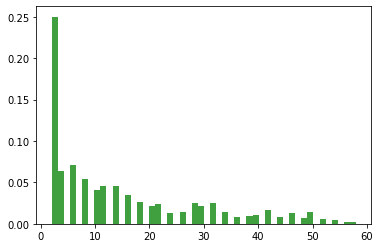

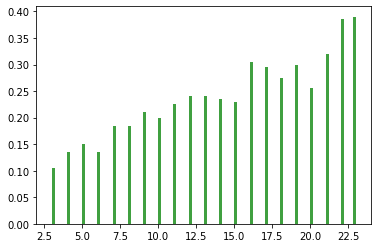

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline  


lengthes, targets = get_stats_from_examples(train_examples[0])

n, bins, patches = plt.hist(lengthes, 50, density=True, facecolor='g', alpha=0.75)
plt.show()

n, bins, patches = plt.hist(targets, 100, density=True, facecolor='g', alpha=0.75)
plt.show()

In [12]:
targets

[17,
 10,
 18,
 7,
 10,
 16,
 23,
 9,
 13,
 18,
 15,
 13,
 13,
 16,
 17,
 16,
 17,
 21,
 16,
 18,
 22,
 6,
 22,
 11,
 7,
 11,
 15,
 12,
 6,
 17,
 6,
 10,
 16,
 16,
 18,
 13,
 23,
 21,
 21,
 18,
 13,
 7,
 7,
 7,
 18,
 14,
 7,
 13,
 5,
 20,
 6,
 19,
 12,
 14,
 18,
 13,
 22,
 7,
 23,
 9,
 16,
 21,
 13,
 7,
 14,
 20,
 3,
 5,
 15,
 8,
 21,
 12,
 16,
 23,
 19,
 23,
 12,
 17,
 11,
 18,
 12,
 18,
 13,
 22,
 9,
 23,
 23,
 17,
 22,
 5,
 7,
 22,
 17,
 19,
 16,
 19,
 23,
 14,
 16,
 21,
 14,
 20,
 5,
 13,
 22,
 19,
 11,
 4,
 23,
 22,
 5,
 23,
 14,
 15,
 20,
 13,
 19,
 8,
 17,
 18,
 3,
 10,
 9,
 10,
 11,
 16,
 16,
 23,
 13,
 5,
 20,
 20,
 21,
 17,
 19,
 22,
 16,
 19,
 18,
 3,
 18,
 12,
 5,
 13,
 22,
 4,
 18,
 18,
 3,
 23,
 16,
 10,
 6,
 15,
 9,
 11,
 21,
 22,
 4,
 9,
 20,
 22,
 5,
 22,
 15,
 21,
 15,
 21,
 10,
 22,
 14,
 19,
 14,
 10,
 7,
 22,
 23,
 10,
 18,
 15,
 9,
 10,
 10,
 22,
 23,
 10,
 19,
 20,
 14,
 11,
 12,
 8,
 19,
 8,
 18,
 17,
 15,
 20,
 22,
 21,
 14,
 11,
 3,
 23,
 21,
 7,
 9,
 6,
 11,


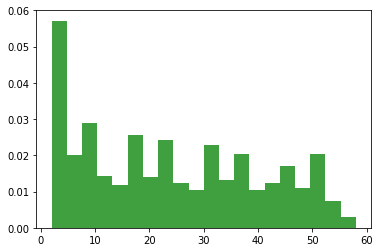

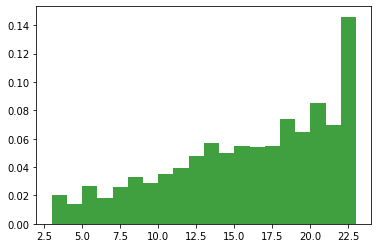

In [13]:


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline  


lengthes, targets = get_stats_from_examples(dev_examples)

n, bins, patches = plt.hist(lengthes, 20, density=True, facecolor='g', alpha=0.75)
plt.show()

n, bins, patches = plt.hist(targets, 20, density=True, facecolor='g', alpha=0.75)
plt.show()

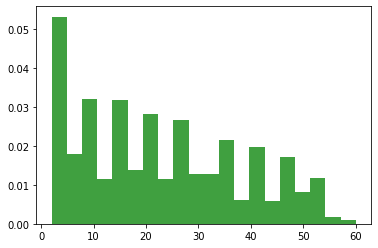

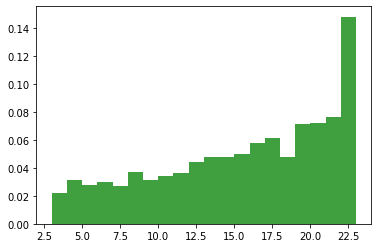

In [14]:


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline  


lengthes, targets = get_stats_from_examples(test_examples)

n, bins, patches = plt.hist(lengthes, 20, density=True, facecolor='g', alpha=0.75)
plt.show()

n, bins, patches = plt.hist(targets, 20, density=True, facecolor='g', alpha=0.75)
plt.show()

In [15]:
print(task.decode(task.encode(str("1 + 1").split())))


['1', '+', '1']


In [21]:
i = np.random.randint(len(train_examples[0]))
i = 11
print(i, len(train_examples[0][0]))
example_inputs, example_targets = list(zip(train_examples[0][0], train_examples[0][1]))[i]
print(' '.join(task.decode(example_inputs)).replace('<pad>',''))
print(eval(' '.join(task.decode(example_inputs)).replace('<pad>','').replace('<eos>', '')))

print(task.decode((example_targets)))


print(' '.join(task.decode(example_inputs)).replace('<pad>',''))
print(eval(' '.join(task.decode(example_inputs)).replace('<pad>','').replace('<eos>', '')))

print(example_targets)


11 1000
0 <eos>                                                        
0
['0']
0 <eos>                                                        
0
tf.Tensor([13], shape=(1,), dtype=int64)


In [19]:
model_1 = EncodingTransformer(transformer_params, task, "model_1")
model_2 = EncodingTransformer(transformer_params, task, "model_2")

trainer = Seq2SeqTrainer(transformer_params, model_1, task)
distiller = Seq2SeqDistiller(transformer_params, model_1, model_2, trainer)
    
trainer.compute_loss(tf.one_hot(example_targets,10),example_targets)

InvalidArgumentError: logits and labels must be broadcastable: logits_size=[1,10] labels_size=[1,16] [Op:SoftmaxCrossEntropyWithLogits] name: loss/smoothing_cross_entropy/softmax_cross_entropy_with_logits/

In [20]:
example_targets

<tf.Tensor: id=3622, shape=(1,), dtype=int64, numpy=array([9])>

In [21]:
tf.one_hot(example_targets,16)

<tf.Tensor: id=5344, shape=(1, 16), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [22]:
from distill.common.metrics import padded_cross_entropy_loss, get_eval_metrics, cross_entropy_loss

In [23]:
entropy, weights = cross_entropy_loss(tf.one_hot(example_targets,10),example_targets,smoothing=0.0,vocab_size=10)

In [24]:
weights

<tf.Tensor: id=5410, shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>

In [25]:
entropy

<tf.Tensor: id=5406, shape=(1,), dtype=float32, numpy=array([1.4611502], dtype=float32)>

In [26]:
soft_targets = tf.one_hot(
            tf.cast(example_targets, tf.int32),
            depth=10,
            on_value=1.0,
            off_value=0.0)
              
      
      
xentropy = tf.nn.softmax_cross_entropy_with_logits_v2(
  logits=soft_targets*100, labels=soft_targets)

In [27]:
xentropy

<tf.Tensor: id=5453, shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>

In [28]:
soft_targets

<tf.Tensor: id=5419, shape=(1, 10), dtype=float32, numpy=array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)>

In [29]:
tf.one_hot(example_targets,10)

<tf.Tensor: id=5459, shape=(1, 10), dtype=float32, numpy=array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)>

In [30]:
model.create_vars()
outputs = model.apply(train_examples)

NameError: name 'model' is not defined

In [23]:
outputs.shape

TensorShape([Dimension(1000), Dimension(1), Dimension(10)])

In [24]:
tf.nn.softmax(outputs)

<tf.Tensor: id=40896, shape=(1000, 1, 10), dtype=float32, numpy=
array([[[0.00715524, 0.09209497, 0.0917704 , ..., 0.03556783,
         0.04943119, 0.15343009]],

       [[0.02895103, 0.04006007, 0.26865193, ..., 0.00580688,
         0.07627358, 0.02107685]],

       [[0.04077142, 0.02672941, 0.23326753, ..., 0.00361042,
         0.04985133, 0.04474999]],

       ...,

       [[0.01969549, 0.02658502, 0.2711329 , ..., 0.00517109,
         0.05861397, 0.04302977]],

       [[0.02205601, 0.05488703, 0.26217592, ..., 0.00449226,
         0.06337234, 0.0239463 ]],

       [[0.04000373, 0.05206897, 0.24202158, ..., 0.01508354,
         0.07866572, 0.02239132]]], dtype=float32)>

In [40]:
outputs['trainable_vars']

[]

In [41]:
model.scope

'Transformer'

In [31]:
g = tf.Graph()
with g.as_default():
    model_1.create_vars(False)
    model_2.create_vars(False)
    print(tf.trainable_variables("model_1"))
    print(tf.trainable_variables("model_2"))

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
[<tf.Variable 'model_1/TransformerEncoder/layer_norm_scale:0' shape=(300,) dtype=float32_ref>, <tf.Variable 'model_1/TransformerEncoder/layer_norm_bias:0' shape=(300,) dtype=float32_ref>]
[<tf.Variable 'model_2/TransformerEncoder/layer_norm_scale:0' shape=(300,) dtype=float32_ref>, <tf.Variable 'model_2/TransformerEncoder/layer_norm_bias:0' shape=(300,) dtype=float32_ref>]


In [35]:
model = EncodingTransformer(transformer_params, task)
model.create_vars(False)
print(tf.trainable_variables())

[]


In [39]:
g = tf.Graph()
with g.as_default():
    model_1.create_vars(False)
    model_2.create_vars(False)
    model_1_vars = tf.trainable_variables("model_1")
    model_2_vars = tf.trainable_variables("model_2")
    print(model_2_vars)
    print(model_1_vars + model_2_vars)

[<tf.Variable 'model_2/TransformerEncoder/layer_norm_scale:0' shape=(300,) dtype=float32_ref>, <tf.Variable 'model_2/TransformerEncoder/layer_norm_bias:0' shape=(300,) dtype=float32_ref>]
[<tf.Variable 'model_1/TransformerEncoder/layer_norm_scale:0' shape=(300,) dtype=float32_ref>, <tf.Variable 'model_1/TransformerEncoder/layer_norm_bias:0' shape=(300,) dtype=float32_ref>, <tf.Variable 'model_2/TransformerEncoder/layer_norm_scale:0' shape=(300,) dtype=float32_ref>, <tf.Variable 'model_2/TransformerEncoder/layer_norm_bias:0' shape=(300,) dtype=float32_ref>]


In [3]:
def binary_math_tree_generator(length, numbers, ops, max_value, depth=0, max_depth=None):
  if max_depth == None:
      max_depth = length
  if length == 1:
    return str(np.random.choice(numbers)), 0
  else:
    left_length = np.random.randint(1,length)
    right_length = length - left_length
    left_child_val = -1
    while left_child_val < 0 or left_child_val > max_value:
      left_child, depth_left = binary_math_tree_generator(left_length, numbers, ops, max_value, depth, max_depth)
      left_child_val = eval(left_child)

    right_child_val = -1
    while right_child_val < 0 or right_child_val > max_value:
      right_child, depth_right = binary_math_tree_generator(right_length, numbers, ops, max_value, depth, max_depth)
      right_child_val = eval(right_child)

    op = np.random.choice(ops)

    depth = max([depth_left, depth_right])
    add_paranthesis = np.random.choice([True, False])
    if add_paranthesis == True and depth < max_depth:
      exp = ' '.join(['(',left_child,op,right_child,')'])
      depth += 1
    else:
      exp = ' '.join([left_child, op, right_child])

    #print(exp, '= ', eval(exp))
    return exp, depth


In [8]:
import scipy.stats as stats
from tqdm import tqdm


max_length = 10
forbidden_lengths = [3]
num_of_symbols = 10
max_depth = 2
number_of_examples = 2000
mode="train"

possible_lengths = list(set(np.arange(1,max_length+1)) - set(forbidden_lengths))

N = len(possible_lengths)
x = np.arange(N, 0, -1)
a = 0.6
weights = x ** (-a)
weights /= weights.sum()
bounded_zipf = stats.rv_discrete(name='bounded_zipf', values=(x, weights))

budgets = {}
max_value = num_of_symbols - 1
max_output_freq = (number_of_examples / num_of_symbols) * 2
print("max_output_freq: ", max_output_freq)
for i in tqdm(np.arange(number_of_examples)):
  exp = -num_of_symbols
  exp_str = '-'+str(num_of_symbols)
  while exp < -int(num_of_symbols/2) or exp > int(num_of_symbols/2):

    if mode == "train":
      length_index = bounded_zipf.rvs(size=1)[0]-1
    else:
      length_index = np.random.randint(len(possible_lengths))

    length = possible_lengths[length_index]  
    exp_str, _ = binary_math_tree_generator(length, np.arange(-int(num_of_symbols/2),int(num_of_symbols/2)+1), ['-','+'], max_value, 0, max_depth)
    exp = eval(exp_str)
    if exp >= -int(num_of_symbols/2) and exp >= -int(num_of_symbols/2):
        if exp not in budgets:
          budgets[exp] = 1
        budgets[exp] += 1
        if budgets[exp] > max_output_freq:
          exp = -num_of_symbols
          exp_str = '-'+str(num_of_symbols)

  exp_tokens = exp_str.split() + [task.eos]
  output = [str(exp)]

  print(exp_str," = ", str(exp))

  5%|▌         | 109/2000 [00:00<00:01, 1081.71it/s]

max_output_freq:  400.0
4 - ( ( 1 - 1 + 2 + 1 ) - 1 + ( 1 + 3 ) )  =  -2
2  =  2
-2  =  -2
5  =  5
( ( 3 - 0 ) + 0 - 3 - 1 + 0 + 2 )  =  1
( 0 + 3 - ( 5 - 5 ) ) - 5  =  -2
( 1 + 2 - 3 + 1 + 5 + 1 + 2 - 5 - 2 + 1 )  =  3
0 - ( 1 + 3 + 4 - ( 1 - 0 + 2 - 0 ) )  =  -5
0 + 1 + ( 3 - 3 ) + 5 - 5 - ( 3 + 4 - 3 )  =  -3
5 - 3 - ( 5 + 0 )  =  -3
5  =  5
( 4 - 3 )  =  1
-3  =  -3
2 - 0 - 1 - 0 + 4 + ( 1 - ( 0 + 0 - 0 ) ) - 4  =  2
( ( 3 + 3 - 5 - 1 ) + 2 )  =  2
( 2 + 1 + 2 - 4 + 5 - 2 ) - ( 2 + 2 )  =  0
( 1 - 4 )  =  -3
( 2 + 2 - 3 + ( 5 - 1 ) - ( 2 - 1 ) )  =  4
1  =  1
2 - 0 + ( 3 - 3 ) + 2 + ( 3 - 2 )  =  5
1 - ( 0 + ( 0 + 1 ) ) + ( 3 - 1 )  =  2
( 5 + 1 - ( 1 + 2 ) ) - ( 0 - 0 + 1 )  =  2
1 - 3  =  -2
( ( 2 + 3 - 2 ) - 0 )  =  3
1 + ( ( 3 - 2 - 5 + 4 ) + 0 )  =  1
-3  =  -3
4 - 3 - 0 + ( 5 - 5 )  =  1
( 4 + 1 ) - ( 5 + ( 2 - 2 ) - 3 + 5 ) - ( 4 + 0 ) + 4  =  -2
2  =  2
( 1 - 1 ) + ( 4 + 3 ) - 2 - 3  =  2
4  =  4
( 2 + 3 + 0 - ( 5 - 0 ) + 3 + 4 - 3 )  =  4
4 - ( ( 5 - 5 ) + 3 )  =  1
3  =  

 15%|█▍        | 294/2000 [00:00<00:01, 985.02it/s] 

  =  -1
-3  =  -3
1 + 1 - ( ( 5 - 2 ) + 1 ) + ( 0 - 0 + 4 ) - 0  =  2
-1  =  -1
2  =  2
5 - 3  =  2
1 - 3  =  -2
-5  =  -5
( 2 + 0 ) - ( ( 4 - 2 + 2 ) - 4 )  =  2
( ( 5 + 1 ) - ( 2 - 2 ) - 1 )  =  5
-4  =  -4
-3  =  -3
0 - 1  =  -1
( 3 - 0 )  =  3
( ( 1 + 1 ) - 1 - 3 + 3 ) - 3  =  -2
( ( 2 - 1 ) - ( 3 + 1 - 1 - 0 ) )  =  -2
4 - 5  =  -1
( ( 5 - 2 ) - 0 - 2 )  =  1
5 - ( 1 - 1 + 1 ) - ( 4 + 0 + 3 - ( 2 + 5 ) )  =  4
3 + 2  =  5
-2  =  -2
0  =  0
( 0 - 1 )  =  -1
5  =  5
5 - ( 4 - 1 ) + ( 4 - 3 + 1 + 4 ) - ( 4 + ( 4 - 4 ) )  =  4
-5  =  -5
-3  =  -3
( 5 + 4 - 5 - 5 + 2 ) - ( 0 + 2 )  =  -1
5 - 2  =  3
4  =  4
-2  =  -2
1 - ( 1 - 2 + 1 + ( 3 + 0 + 1 ) )  =  -3
-5  =  -5
( ( 5 - 1 - 3 ) + 1 + 2 + 0 )  =  4
1  =  1
4  =  4
( ( 0 + 4 - 4 ) + 0 ) - ( 3 + 2 )  =  -5
2  =  2
1 - ( ( 2 + 1 ) - ( 2 - 0 ) ) + ( ( 1 + 0 ) + 2 ) - ( 3 - 3 )  =  3
-2  =  -2
( 1 - 3 )  =  -2
( 0 + 1 ) + 3 + 0 + 0 + 1  =  5
5 - 0  =  5
( 0 + 0 ) + 0 - ( 3 - ( 5 - 1 - 3 + 2 ) ) + 3  =  3
3  =  3
-5  =  -5
0 + 4  =  4
1 

 29%|██▉       | 587/2000 [00:00<00:01, 988.23it/s]

  =  4
4  =  4
2 + ( 1 + 4 - 4 ) + 1  =  4
-1  =  -1
3  =  3
-3  =  -3
5  =  5
2 - 2 + 5 + ( 4 - 2 ) - ( ( 3 + 5 ) - 0 ) - ( 5 - 1 )  =  -5
1  =  1
4 - ( ( 4 + 0 ) + 1 - 0 - 0 - 4 + 4 )  =  -1
-3  =  -3
( ( 3 - 2 ) - 1 - 0 + 0 - 4 )  =  -4
1  =  1
2 - 0 - ( 0 + ( 1 + 2 - 0 ) + 3 )  =  -4
1 + 1 - 4 - 3 + ( 5 - 2 )  =  -2
2 - 4 - ( 0 + 0 + ( 5 - 5 ) ) + 2  =  0
3  =  3
0  =  0
-2  =  -2
3  =  3
2 + 3  =  5
( 4 + 3 - 3 ) - ( 5 + 4 - 2 )  =  -3
( 4 - 3 )  =  1
1 - 0 - ( ( 0 + 3 - 3 ) + 1 + 0 ) - 2 + 2  =  0
-2  =  -2
( 1 - ( 0 + 1 ) ) + 1 + 0  =  1
( 0 - 4 )  =  -4
0 + 5  =  5
-1  =  -1
1  =  1
0 + 1  =  1
1  =  1
( ( 2 + 0 ) + ( 4 - 3 ) - 0 - 0 ) + 1  =  4
1 - 3  =  -2
5 - 4  =  1
4 - 2 + 2 - ( 3 + 3 + 3 - ( 2 - 2 ) - 3 )  =  -2
( 5 - 1 ) - 0 + ( 5 - 5 )  =  4
-1  =  -1
( ( 0 + 0 ) + 4 - ( 4 + 3 ) )  =  -3
3  =  3
2 + 3  =  5
5  =  5
( 3 - 4 + 2 + 0 )  =  1
( ( 3 - 3 ) + 4 - 4 + 3 - 3 + ( 0 + 3 ) )  =  3
( ( 4 + 2 - 1 - 5 + 2 ) - ( 4 - 2 ) + 0 + 0 )  =  0
2 - 2 + ( ( 3 + 0 ) + 0 )  =  3
3

 38%|███▊      | 768/2000 [00:00<00:01, 931.66it/s]

 =  3
3  =  3
2 + 0 - ( 2 + 1 + 2 - 2 )  =  -1
-3  =  -3
-1  =  -1
0 + ( 3 + 1 ) - 1 - 1 - 1  =  1
1 + ( 5 - 0 ) - ( 4 + 0 ) - ( 5 - 2 )  =  -1
4 - 3 - ( 0 + 0 )  =  1
3 - 0  =  3
-3  =  -3
0 - 4  =  -4
-4  =  -4
( ( 2 - 1 ) + 1 ) + ( ( 2 + 0 ) - 1 + 0 )  =  3
0  =  0
0  =  0
( 4 + 0 ) - 0 + 1  =  5
3 + ( ( 0 + 5 ) - 3 ) + 4 + 4 - 5 - 3  =  5
-2  =  -2
1  =  1
-5  =  -5
1 + 1  =  2
( 2 - 3 + 1 + 0 )  =  0
5  =  5
( 5 - ( 2 - 1 ) - 2 ) - ( ( 5 + 1 ) - ( 5 + 1 ) )  =  2
-3  =  -3
3  =  3
( 5 - 4 + ( 2 + 0 ) )  =  3
2 + 3 - ( ( 4 + 3 ) + 1 )  =  -3
2  =  2
1 - 5 + 0 + ( ( 4 - 2 - 2 ) + 0 + 0 )  =  -4
( 0 + 2 )  =  2
0  =  0
1 + ( ( 1 + 1 ) + 3 ) - 1 - 3 - ( 5 + 2 )  =  -5
4  =  4
2  =  2
( 2 + 1 ) - ( 3 + 2 - ( 4 + 0 ) + 2 )  =  0
5  =  5
( 5 + ( 4 - 0 + 0 ) - ( 5 + 2 ) )  =  2
-1  =  -1
4 + 4 - ( 3 + 0 ) - 0 - 2 - 1  =  2
-3  =  -3
3  =  3
3 + 2  =  5
( 0 + 1 ) + 5 - 4  =  2
3  =  3
( 5 - 5 )  =  0
-2  =  -2
-4  =  -4
( 1 + 4 + 1 - 4 ) - ( 4 - 2 )  =  0
3 - 4  =  -1
5 - 4  =  1
-4  =  -4

 44%|████▍     | 875/2000 [00:00<00:01, 969.22it/s]

5
3  =  3
1 + ( 0 + 0 ) - 0  =  1
0 - 4  =  -4
2 + ( ( 3 + 2 ) - 3 ) + 0  =  4
( 5 - 5 )  =  0
-4  =  -4
( 1 - 0 )  =  1
( 4 - 5 + 4 ) - ( 1 - ( 2 - 1 ) ) - ( 3 - 3 ) + 0  =  3
4  =  4
5 - 2 + ( 3 - 2 )  =  4
-3  =  -3
4 - 1  =  3
-2  =  -2
0 - ( 2 - 1 + 3 )  =  -4
( 5 - 1 ) - ( 5 - ( 0 + 2 ) ) + ( 2 - 2 + 1 + 0 )  =  2
4 - 5  =  -1
( ( 1 + 5 ) - 5 ) + 1  =  2
5 + 2 - 4 - 1  =  2
3  =  3
2  =  2
-1  =  -1
( 5 - 1 )  =  4
-4  =  -4
( 1 + 3 )  =  4
( 5 - ( 4 - 0 ) ) - 2  =  -1
( 3 - ( 5 - 5 + 5 ) )  =  -2
1 + 3  =  4
2 + 0 - 5 + 4 + ( 5 - ( 4 - 0 ) )  =  2
-3  =  -3
-1  =  -1
2 + ( 5 - 4 ) - ( 0 + 2 + 2 )  =  -1
-2  =  -2
-3  =  -3
( 2 + 2 )  =  4
-3  =  -3
4  =  4
2  =  2
1  =  1
( 5 + 0 )  =  5
( ( 0 + 1 ) + 3 ) - 5 + 4  =  3
1 - ( ( 2 + 3 ) - 4 ) - 2 + ( 0 - 2 + 5 )  =  1
( 2 + 2 ) + ( 4 - 3 )  =  5
( 5 - 4 ) + ( 3 - 0 + 0 ) - 2 + 0  =  2
( 3 - 4 )  =  -1
2 - ( 1 + 2 ) + 5 - ( 0 + ( 3 + 1 ) )  =  0
( ( 4 + 2 ) - ( 5 + 1 ) ) + 2 + 1  =  3
( 1 - 5 )  =  -4
1 + 4  =  5
-5  =  -5
1 + ( 5 

 58%|█████▊    | 1163/2000 [00:01<00:00, 912.43it/s]


2  =  2
( 0 + 3 - ( 2 + 0 ) ) + 3  =  4
( 2 - 3 )  =  -1
1 + 3 - 2 + 4 - 1 + 0  =  5
( 5 + 0 ) - 3 + ( 5 - 3 - ( 4 - 5 + 2 ) )  =  3
( 5 - 5 - 2 - ( 2 - 2 ) )  =  -2
2 - 2  =  0
-5  =  -5
-4  =  -4
5  =  5
( ( 4 + 0 - 2 ) + 1 ) - 1 + ( 2 - 1 + 0 + 0 )  =  3
-3  =  -3
1 - 3  =  -2
-3  =  -3
( 5 + 0 - 0 ) + ( 3 - ( 0 + 2 ) ) - ( ( 0 + 4 ) - 3 )  =  5
( 0 - 0 + 5 - 0 )  =  5
4  =  4
4 - 2  =  2
( 4 + 5 ) - ( 0 + ( 4 + 4 - 3 ) + ( 2 - 0 ) )  =  2
( ( 2 - 1 ) + 1 + 1 )  =  3
3  =  3
5 - ( 2 + 4 + ( 2 - 0 ) )  =  -3
2  =  2
0 + 3 + ( 2 - 0 - 0 - ( 1 + 1 ) ) + ( ( 1 - 0 ) + 1 )  =  5
( 2 - ( 3 - 2 ) ) + 3 - 2  =  2
( 0 - 1 )  =  -1
0  =  0
( ( 0 + 4 ) - 2 ) + 0 + 1  =  3
5 - 5 - 0 - 1  =  -1
( 1 + 3 )  =  4
( 0 + 1 - 0 + 5 - 1 ) - 2  =  3
-1  =  -1
( 2 + 1 + 0 - 3 + ( 2 + 2 ) )  =  4
4  =  4
4 + 1 - 5 + 0  =  0
4 - 5 - 0 - 3 + 4 + 1 + ( ( 1 + 1 ) + 0 ) - 2  =  1
2 - 4 + ( ( 1 + 5 ) + 0 ) - 5  =  -1
2  =  2
1  =  1
1  =  1
( 5 - 0 )  =  5
( 1 - 0 + 0 ) - ( 1 - ( 1 - 0 ) )  =  1
-4  =  -4
( 3 

 69%|██████▉   | 1377/2000 [00:01<00:00, 978.33it/s]

4 - 3 + 5 - 5  =  1
0  =  0
-3  =  -3
( 2 + ( 3 + 4 ) - ( 4 + 1 ) - 1 + 3 - 3 )  =  3
( ( 1 + 1 + 0 ) - 5 )  =  -3
( 0 + 5 - 5 - 3 )  =  -3
-5  =  -5
0 + 0 + 0 + 1 - 4 + ( 2 + 2 + ( 5 - 5 ) )  =  1
( 0 + 2 ) + 5 - 3 - 1  =  3
( ( 2 + 2 - 0 ) + 4 - 0 - 1 - 4 )  =  3
( 4 - 2 ) - ( ( 2 + 1 ) - 1 ) - ( 5 - 5 + 0 ) + ( 0 + 4 )  =  4
( 5 - ( 0 + 5 ) + 1 )  =  1
( ( 1 + 4 ) - 1 ) - 4 + 3  =  3
( 3 + 3 - 4 - 2 )  =  0
4 - 4  =  0
-5  =  -5
3  =  3
2 - ( 1 + 0 - 1 - 0 ) - 3  =  -1
4 - ( ( 0 + 2 + 5 ) - ( 1 - 1 ) )  =  -3
( 2 - 1 + 4 - 5 ) + 2 + 1  =  3
2  =  2
( ( 1 - 0 ) - 2 - 1 )  =  -2
( 1 + ( 4 - 3 ) ) + 1 + ( 5 - 3 ) - ( ( 4 - 3 ) + 1 )  =  3
-5  =  -5
2 + 3 - 4 + 0 - 3  =  -2
( 2 - ( 4 - 0 ) + 5 ) + 5 - ( 5 + 3 )  =  0
-2  =  -2
5 + 0 - ( 0 + 3 )  =  2
( ( 4 - 2 ) - ( 5 - 3 ) )  =  0
3  =  3
-5  =  -5
( 3 - 3 )  =  0
0 + ( ( 5 - 3 + 1 ) - ( 3 - 0 ) )  =  0
( 3 - 4 + ( 0 - 2 + 4 ) ) - ( 0 + 4 )  =  -3
( 1 - 2 + 3 ) - ( ( 2 - 2 ) + 1 ) - 0 + ( 1 + 3 )  =  5
2  =  2
5 - 3 + 5 - 3 - 2  =  2
5

 74%|███████▍  | 1476/2000 [00:01<00:00, 869.77it/s]

 4
1  =  1
( 4 - ( 5 - 3 ) ) - ( 3 + 2 - 5 - 2 + 2 ) + 1 - 3  =  0
2 + 0 + 2 - 1 - 1  =  2
5  =  5
( 3 + 5 ) - ( 4 + 5 ) - ( 5 - 3 )  =  -3
( 4 - 5 )  =  -1
-2  =  -2
( 1 + 3 + ( 1 + 0 ) ) - 1 - 2  =  2
( 4 - 3 )  =  1
3 - 4  =  -1
( 5 - ( 4 - 1 ) ) - ( ( 0 + 3 ) + 2 - 0 )  =  -3
3  =  3
4 - 4  =  0
0  =  0
4 - ( ( 2 - 4 + 3 + 2 ) + 2 - 2 )  =  1
3 + ( 1 + ( 5 - 2 ) ) - 3  =  4
-2  =  -2
-5  =  -5
0 + 2  =  2
( ( 4 + 0 ) - 1 - 1 )  =  2
2 - ( 4 - 1 ) + 3 - ( ( 3 - 2 ) + 0 - 2 + 4 + 2 )  =  -3
( 4 + 4 - 2 - 2 )  =  4
( 0 - 2 )  =  -2
( 1 + ( 1 + 0 ) - ( 5 - 4 ) ) + ( 1 - 1 ) + ( 0 - 0 )  =  1
( 4 + 5 + 0 ) - 5 - 5 + ( ( 2 - 2 ) + 0 )  =  -1
0 - ( 5 + 1 ) + 1  =  -5
( 4 - 0 )  =  4
( 1 + 3 ) - ( ( 1 + 5 ) - 4 )  =  2
( 4 + 0 )  =  4
4 + 0  =  4
( 5 - 3 )  =  2
0  =  0
5  =  5
( ( 4 - 0 ) - ( 5 - 3 ) + 2 ) + ( 5 - 2 - ( 0 - 1 + 3 ) )  =  5
-3  =  -3
( 3 - 5 )  =  -2
3 - 1  =  2
( 0 - 0 )  =  0
3  =  3
-1  =  -1
( 3 - 3 )  =  0
-2  =  -2
5 + 3 - 1 - ( 3 + 2 - 2 )  =  4
( ( 3 - 2 + 3 ) + ( 

 84%|████████▎ | 1671/2000 [00:01<00:00, 914.43it/s]

 -2
-3  =  -3
( 5 + 4 ) - 1 - ( 3 + 0 )  =  5
( 1 - 0 - 3 + 3 - 0 - 0 )  =  1
-5  =  -5
4  =  4
2 - 1 - 3 - 1 + 3 + 4 - 3 - 1  =  0
( 0 + 2 )  =  2
3 - ( ( 4 + 4 ) - 5 ) - 1 + 2 + ( 3 - 4 + 2 )  =  2
3 - 2  =  1
1  =  1
4  =  4
( 0 + ( 0 + 4 ) - 1 - 0 ) - ( 1 + 5 )  =  -3
-4  =  -4
2 + ( 0 + ( 3 + 1 ) - 4 ) - 2 + 3 - ( 5 + ( 0 - 0 ) )  =  -2
-5  =  -5
( 1 + 5 + 2 - 0 ) - ( 3 + ( 1 + 2 ) )  =  2
( 3 + 2 )  =  5
( 5 - 0 - ( 4 + 5 ) )  =  -4
( 3 - 3 ) + 3 + 3 - 4 - ( 3 + 3 - 4 )  =  0
-1  =  -1
0  =  0
0 + ( 0 + 1 + ( 3 + 1 ) ) - 3 - 3 + 1  =  0
-2  =  -2
4 - ( ( 2 + 3 ) - 0 )  =  -1
1  =  1
4 - ( 1 + 4 - 1 ) - 1  =  -1
( ( 1 - 2 + 2 ) + 0 ) + 3  =  4
5 - ( ( 0 + 5 + 3 ) + 1 )  =  -4
( 4 + 0 )  =  4
2 - 0  =  2
( 1 + 2 ) + ( ( 3 - 2 ) + 1 ) - ( 1 - 0 )  =  4
2 - 0  =  2
5  =  5
-2  =  -2
1 - 4  =  -3
4  =  4
0 + 4 - ( 1 + 4 )  =  -1
2 - 1  =  1
( ( 0 + 2 ) + 3 ) - ( 5 + 3 )  =  -3
4  =  4
-5  =  -5
( 3 - 4 + 3 + 2 )  =  4
( 1 - 3 + 3 + 1 - 1 + 5 - 1 )  =  5
0  =  0
( 4 - 3 + 3 ) + ( ( 3 +

 93%|█████████▎| 1851/2000 [00:02<00:00, 827.18it/s]

  =  5
1 + ( 1 + 4 ) - 3  =  3
-4  =  -4
4  =  4
( 1 + 0 - ( 1 - 1 ) )  =  1
-2  =  -2
( 2 - ( 3 + 1 + 2 ) )  =  -4
( 3 + 2 - ( 4 - 0 + 4 - 4 ) )  =  1
( 2 + 0 - ( 1 + 0 ) - 1 + 2 + ( 0 + 2 ) )  =  4
5  =  5
1 + 5 - 5 - 0 + 2  =  3
0 - ( 0 + 0 ) + ( 2 - 0 )  =  2
( ( 5 + 0 ) - ( 4 - 3 ) )  =  4
( 3 + ( 1 - 1 ) + ( 5 - 3 ) )  =  5
( 4 - 2 ) + 1 - ( 4 - ( 2 + 0 ) + 0 )  =  1
( 2 - 2 + 5 - 2 - 1 + 3 )  =  5
3  =  3
1 + 3 - 4 + 5  =  5
-2  =  -2
( 5 + 1 - 2 - 1 ) - ( 5 - 4 )  =  2
( 1 + 2 )  =  3
2 - 3 + 5 + 1  =  5
-2  =  -2
-4  =  -4
-2  =  -2
( 5 + 1 - 5 + 0 ) - ( 2 - ( 1 + 0 ) ) + 4 - 0 + 0  =  4
-3  =  -3
-3  =  -3
-1  =  -1
( 0 + 3 )  =  3
( 5 - ( 2 + 0 ) ) + ( 0 + 0 ) - 3 + 2 - 2  =  0
-4  =  -4
5  =  5
( 1 + 0 + 0 ) + ( ( 3 - 1 ) + 2 - 4 + 2 + 4 - 3 )  =  4
( ( 2 + 5 - 5 ) + 3 - ( 0 + 5 ) )  =  0
( 4 - 2 )  =  2
4  =  4
( 0 + 4 - 4 ) - 2 - 2 + ( 0 + 2 )  =  -2
2  =  2
( 1 + ( 5 - 5 ) ) - 5 + 3 - 4 + 1  =  -4
( ( 4 - 0 ) + 2 - ( 4 - 3 + 4 ) - 0 )  =  1
( 5 - 4 + 4 - 3 ) + ( ( 5 - 4 

100%|██████████| 2000/2000 [00:02<00:00, 903.21it/s]

  =  5
( ( 4 - 2 ) - 5 + 3 ) + 3 - 3  =  0
-5  =  -5
4 - ( ( 0 + 3 ) - 0 + 3 )  =  -2
3  =  3
-3  =  -3
( 5 - 0 + 0 ) - ( 5 + 4 )  =  -4
( 5 + 2 ) - ( ( 1 + 3 ) - 2 )  =  5
3 + 0 + ( 0 + 2 ) - ( 3 - 2 )  =  4
0 + ( ( 5 - 3 ) + 3 ) - 0  =  5
( 2 + 5 - 5 ) - ( ( 2 - 0 ) + 1 )  =  -1
( 2 - 3 )  =  -1
1 + 5 - 0 + 4 - 1 - ( ( 1 - 3 + 4 ) - 2 + 4 )  =  5
3 - 2 - 3 + 5 + 2  =  5
( 1 + 2 )  =  3
1 + ( ( 4 - 1 ) - 3 ) + 3  =  4
( 1 + 0 + 2 + ( 5 + 1 - 2 - 0 + 1 ) ) - 4 - 3  =  1
1 + ( 5 + 0 ) - 5 + 1 + 2  =  4
-3  =  -3
( 5 + ( 0 + 2 ) - ( 5 + 0 ) ) - 5 + 4 - 0 + 0  =  1
( ( 3 + 2 ) - 4 + ( 0 + 0 ) )  =  1
( ( 1 + 0 + 1 + 3 + 4 - 2 - 2 ) - 5 - 4 )  =  -4
0  =  0
4  =  4
( 5 - ( 5 - 4 ) - 3 + ( 0 + 4 ) ) - 5 - ( 1 + 1 )  =  -2
4 + ( ( 0 + 0 ) - 0 )  =  4
2 - 4  =  -2
( 3 - 0 )  =  3
( 5 + 1 ) + 0 - 2 + 1  =  5
2  =  2
( 1 + 3 - ( 1 - 1 - 0 ) )  =  4
1 + 2  =  3
-3  =  -3
0 + 2  =  2
( ( 4 - 2 ) + 2 ) + 4 - 5 + 0 + 2  =  5
( 0 - ( 2 + 0 + 2 + 1 - 4 + 1 - 1 + 2 ) )  =  -3
-3  =  -3
2  =  2
5 - 3  